# Adaptation of Hamiltonian Samplers

In Hamiltonian samplers, we construct proposal by emulating Hamiltonian dynamics. This involves using an integrator (in this case, we must use a symplectic integrator to preserve detailed balance). 

As part of the symplectic integrator, you need to choose the `step_size` and number of steps `L`. It can be a little tricky to tune these by hand... Luckily we have some built-in scheme to adapt these parameters

Ones which find optimal hyperparameters during warmup, and sets them statically for the rest of the run:
- **Initial Step Size**: tunes the initial guess for the `step_size` to get a target acceptance rate and have no numerical error.
- **Dual Averaging**: tunes the `step_size` to reach a target acceptance rate.
- **ChEES (Change in the Estimator of the Expected Square)**: tunes the number of integration steps `L`.

And those which adjusts the hyperparameters throughout sampling 
- **NUTS (No-U-Turn Sampler)**: Sets the number of steps `L` dyamically
- **WALNUTS (Within-Orbit Adaptive Leapfrog No-U-Turn-Sampler)**: [Coming soon....] Sets the `step_size` and number of steps `L` dynamically 

In [1]:
import hemcee
import jax
import jax.numpy as jnp

import corner
import matplotlib.pyplot as plt

For this tutorial, we'll sample the Rosenbrock potential. It is known for having extremely narrow regions of high probability, meaning you have to tune the step-size and integration length very carefully.

In [2]:
def log_prob(x: jnp.ndarray) -> float:
    """Rosenbrock potential"""
    x0 = x[..., 0]
    x1 = x[..., 1]
    return -1 * ((1.0 - x0) ** 2 + 100.0 * (x1 - x0 ** 2) ** 2)

total_chains = 100
dim = 2

keys = jax.random.split(jax.random.PRNGKey(0), 2)
initial_states = jax.random.normal(keys[0], (total_chains, dim))

# Default Behavior of `hemcee`

The `hemcee.HamiltonianEnsembleSampler` and `hemcee.HamiltonianSampler` by default having Initial Step Size, Dual Averaging, and ChEES all on!

/Users/clarkmiyamoto/nyu/h-emcee/src/hemcee/backend/backend.py:47: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  self.accepted: jnp.ndarray = jnp.zeros(self.nwalkers, dtype=self.dtype, device=self.device)


Using 100 total chains: Group 1 (50), Group 2 (50)
Using inital step size of 0.004999999888241291
Starting warmup...


100%|██████████| 2000/2000 [00:40<00:00, 49.73it/s]


Warmup complete.
Found step size 0.010159287601709366 and integration length: 25
Starting main sampling...


100%|██████████| 1000/1000 [00:19<00:00, 52.20it/s]


Main sampling complete.
Autocorrelation time: [41.01967 41.53285]


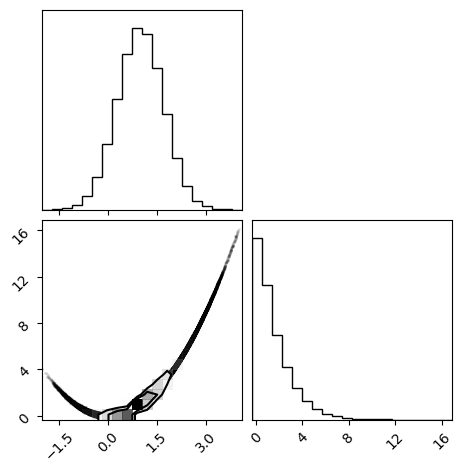

In [ ]:
sampler = hemcee.HamiltonianEnsembleSampler(total_chains, 
                                            dim, 
                                            log_prob, 
                                            step_size = 0.01,
                                            adapt_inital_step_size=True, # Default to `True`, uses default parameters
                                            adapt_step_size=True,        # Default to `True`
                                            adapt_length=True,           # Default to `True`
                                            )
samples = sampler.run_mcmc(keys[1], 
                           initial_states, 
                           num_samples=10**4, 
                           warmup=10**5,
                           thin_by=5,
                           show_progress=True)

try:
    tau = hemcee.autocorr.integrated_time(samples)
    print(f'Autocorrelation time: {tau}')
except Exception as e:
    print(e)

corner.corner(samples.reshape(-1, dim).__array__())
plt.show()

# Modifying the Adapters

Incases where the adapter behavior fails, you can modify it for your purposes.

## Dual Averaging

Dual averaging implementes an optimization scheme to adjust the step-size to reach a target acceptance ratio

- `target_accept`: Target acceptance rate.
- `stepsize_inter`:
- `t0`: Controlls how quickly adaptation begins. Large $t_0$ means adaptation is slower early on, and smaller means adaptation is more reactive.
- `gamma`: Controls how strongly the running dual average is pulled toward the instantaneous noisy update
- `kappa`: Controls the weight given to the running average vs. most recent log‐stepsize. In otherwords, how quickly the optimization scheme "trust" new information. Large $\kappa$ means a more timid algorithm, and vice-versa.
- `agg`: Method to aggregate the acceptance probabilites. Do we do a harmonic average, or a regular mean?

Since the the scheme is affine-invariant, the acceptance ratios are affine invariant. Thus dual averaging itself is also affine invariant.

In [7]:
from hemcee.adaptation import DAParameters

# These are the default / recommended parameters.
da_parameters = DAParameters(
    target_accept = 0.651, # Recommended for ChEES, 0.8 is recommend for NUTS
    stepsize_inter = 0.9,
    t0 = 10.0, # How quickly adaptation begins
    gamma = 0.05,
    kappa = 0.75, #Controls the weight given to the running average vs. most recent log‐stepsize
    agg = 'harmonic' # How to average 'mean' or 'harmonic'
)

# ChEES

The ChEES adapter maximizes the “Change in the Estimator of the Expected Square"
$$
\text{ChEES}(T) \equiv \frac{1}{4} \mathbb E\left[ \big( ( \tilde \theta(T) - \mathbb E[\theta])^2 - (\theta - \mathbb E[\theta] )^2 \big)^2\right]
$$
where $\theta \in \mathbb R^d$ are the current positions of your walkers, and $\tilde \theta(T) \in \mathbb R^d$ is the position of your walkers after being time-evolved (via Leapfrog integrator) for $T (= \epsilon L)$ total time (step size * number of steps). To maximize this quantity, we use the ADAM optimizer.

The current metric is invariant under orthogonal transformations, but we are interested in being invariant to all affine invariant transformations. If you view the vector norm as an inner product, then you can ask, what's the affine invariant inner product. You get
$$
\text{ChEES}_{\Sigma^{-1}}(T) \equiv \frac{1}{4} \mathbb E\left[ \big( ( \tilde \theta(T) - \mathbb E[\theta])^2_{\Sigma^{-1}} - (\theta - \mathbb E[\theta] )^2_{\Sigma^{-1}} \big)^2\right]
$$
where $(\vec v)^2_{\Sigma^{-1}} = \vec v^T \Sigma^{-1} \vec v$, and $\Sigma^{-1}$ is the empirical covariance of the complement ensemble.

Criterion parameters
- `T_min`: Minimum allowed integration time.
- `T_max`: Maximum allowed integration time.
- `T_interpolation`:  

ADAM optimizer parameters
- `lr_T`: Learning rate of ADAM optimizer.
- `beta1`: 1st-moment smoothing (beta1 in ADAM), this is the momentum term.
- `beta2`: 2nd-moment smoothing (beta2 in ADAM).
- `regularization`: Avoids division by zero in the ADAM algorithm.


In [8]:
from hemcee.adaptation import ChEESParameters

# These are the default / recommended parameters.
chees_parameters = ChEESParameters(
    T_min = 0.25, # Minimum allowed integration time
    T_max = 10.0, # Maximum allowed integration time
    T_interpolation = 0.9, 

    # ADAM optimizer parameters
    lr_T = 0.025, # Learning rate of optimizer
    beta1 = 0.0, # 1st-moment smoothing (beta1 in ADAM)
    beta2 = 0.95, # 2nd-moment smoothing (beta2 in ADAM)
    regularization = 1e-7 # Avoids division by zero
) 

We can adjust the behavior of our Hamiltonian sampler by this into the `adapt` arguments

Using 100 total chains: Group 1 (50), Group 2 (50)
Using inital step size of 0.004999999888241291
Starting warmup...


100%|██████████| 2000/2000 [00:38<00:00, 52.01it/s]


Warmup complete.
Found step size 0.010159287601709366 and integration length: 25
Starting main sampling...


100%|██████████| 1000/1000 [00:18<00:00, 54.98it/s]


Main sampling complete.
Autocorrelation time: [41.01967 41.53285]


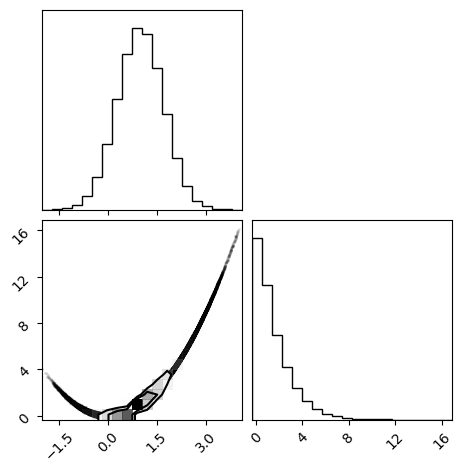

In [10]:
sampler = hemcee.HamiltonianEnsembleSampler(total_chains, 
                                            dim, 
                                            log_prob, 
                                            step_size = 0.01,
                                            adapt_step_size=da_parameters,
                                            adapt_length=chees_parameters,
                                            )

samples = sampler.run_mcmc(keys[1], 
                           initial_states, 
                           num_samples=10**4, 
                           warmup=10**5,
                           thin_by=5,
                           show_progress=True)

try:
    tau = hemcee.autocorr.integrated_time(samples)
    print(f'Autocorrelation time: {tau}')
except Exception as e:
    print(e)

corner.corner(samples.reshape(-1, dim).__array__())
plt.show()

# Turning off adaptation

I want to preface, this is NOT something you should do, and this should only be done in extreme scenarios. But, if for some reason adaptation is giving you a headache, you can disable it. Just plug in `False` into the `adapt` parameters.

/Users/clarkmiyamoto/nyu/h-emcee/src/hemcee/backend/backend.py:47: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  self.accepted: jnp.ndarray = jnp.zeros(self.nwalkers, dtype=self.dtype, device=self.device)


Using 100 total chains: Group 1 (50), Group 2 (50)
Starting warmup...


100%|██████████| 2000/2000 [00:23<00:00, 84.03it/s]


Warmup complete.
Found step size 0.01 and integration length: 10
Starting main sampling...


100%|██████████| 1000/1000 [00:11<00:00, 87.17it/s]


Main sampling complete.
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [210.34383 205.32188]


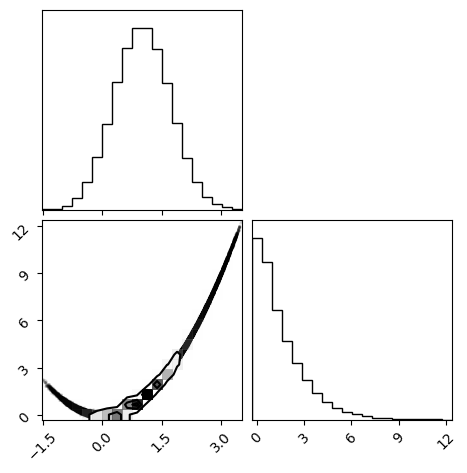

In [ ]:
sampler = hemcee.HamiltonianEnsembleSampler(total_chains, 
                                            dim, 
                                            log_prob, 
                                            step_size = 0.01
                                            adapt_inital_step_size=False, # <- Not recommended, but can be done.
                                            adapt_step_size=False,
                                            adapt_length=False,
                                            )

samples = sampler.run_mcmc(keys[1], 
                           initial_states, 
                           num_samples=10**4, 
                           warmup=10**5,
                           thin_by=5,
                           show_progress=True)

try:
    tau = hemcee.autocorr.integrated_time(samples)
    print(f'Autocorrelation time: {tau}')
except Exception as e:
    print(e)

corner.corner(samples.reshape(-1, dim).__array__())
plt.show()